In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from analytical_models.gde_multi import System
from analytical_models import gde_multi

In [2]:
erc = dict(
    i_0_CO=torch.tensor(0.0125),
    i_0_C2H4=torch.tensor(0.0060), 
    i_0_H2a=0.009789999574422836, 
    i_0_H2b=torch.tensor(0.0060), 
    alpha_CO=torch.tensor(0.4430), 
    alpha_C2H4=torch.tensor(0.4007), 
    alpha_H2a=0.27000001072883606, 
    alpha_H2b=torch.tensor(0.3550)
)
init_args = dict(
        T=298.15, # [K]
        p0=2.38, # [bar]
        Q=30, # [cm^3/min]
        flow_chan_width=1.5e-3, # [m]
        flow_chan_length=0.02, # [m]
        flow_chan_height=0.005, # [m]
        c_khco3=500, # [mol/l]
        c_k=500, # [mol/l]
        dic=10**(-3.408),
        diffusion_coefficients=gde_multi.diffusion_coefficients | {},
        salting_out_exponents=gde_multi.salting_out_exponents | {}, 
        electrode_reaction_kinetics=erc,
        electrode_reaction_potentials=gde_multi.electrode_reaction_potentials | {},
        chemical_reaction_rates=gde_multi.chemical_reaction_rates | {},
)
solve_args = dict(
        i_target=233,
        eps=torch.tensor(0.8),
        r=torch.tensor(40e-9),
        L=torch.tensor(1.835e-5),
        thetas = {
            'CO': 0.6,
            'C2H4': 0.2,
            'H2b': 0.2
        },
        gdl_mass_transfer_coeff=torch.tensor(0.03417),
    )

In [3]:
def set_variation(obj: dict, name: str, fraction: float):
    obj = obj.copy()
    if '.' in name:
        outer = name.split('.')[0]
        inner = '.'.join(name.split('.')[1:])
        x_v, obj_c = set_variation(obj[outer], inner, fraction)
        obj[outer] = obj_c
    else:
        x_v = obj[name] * fraction
        obj[name] = x_v
    return x_v, obj

def enable_grad(obj: dict, name: str):
    obj = obj.copy()
    if '.' in name:
        outer = name.split('.')[0]
        inner = '.'.join(name.split('.')[1:])
        obj[outer] = enable_grad(obj[outer], inner)
    else:
        if not isinstance(obj[name], torch.Tensor):
            v = torch.tensor(obj[name], dtype=torch.float32)
        else:
            v = obj[name]
        obj[name] = torch.nn.Parameter(v)
    return obj

def get_arg(obj: dict, name: str):
    if '.' in name:
        outer = name.split('.')[0]
        inner = '.'.join(name.split('.')[1:])
        return get_arg(obj[outer], inner)
    else:
        return obj[name]

In [4]:
def calc_variation(init_args: dict, solve_args: dict, to_vary: str):
    minus = 0.95
    plus = 1.05
    # base calculation
    S = System(**init_args)
    op = S.solve_current(**solve_args)
    base_fe = op['fe_c2h4']
    init_args_1 = init_args.copy()
    init_args_2 = init_args.copy()
    solve_args_1 = solve_args.copy()
    solve_args_2 = solve_args.copy()
    
    if to_vary.split('.')[0] in solve_args:
        x0 = get_arg(solve_args, to_vary)
        x_minus, solve_args_1 = set_variation(solve_args, to_vary, minus)
        x_plus, solve_args_2 = set_variation(solve_args, to_vary, plus)
    elif to_vary.split('.')[0] in init_args:
        x0 = get_arg(init_args, to_vary)
        x_minus, init_args_1 = set_variation(init_args, to_vary, minus)
        x_plus, init_args_2 = set_variation(init_args, to_vary, plus)
    else:
        raise ValueError(f'Unknown parameter `{to_vary}`')
        
    S = System(**init_args_1)
    op = S.solve_current(**solve_args_1)
    fe_minus = op['fe_c2h4']
    S = System(**init_args_2)
    op = S.solve_current(**solve_args_2)
    fe_plus = op['fe_c2h4']
    
    dfe_dx = (fe_plus - fe_minus) / (x_plus - x_minus)
    return dfe_dx / (base_fe / x0)

def calc_variation_grad(init_args: dict, solve_args: dict, to_vary: str):
    if to_vary.split('.')[0] in solve_args:
        solve_args = enable_grad(solve_args, to_vary)
    elif to_vary.split('.')[0] in init_args:
        init_args = enable_grad(init_args, to_vary)

    # base calculation
    S = System(**init_args)
    op = S.solve_current(**solve_args)
    base_fe = op['fe_c2h4']
    base_fe.backward()
    base_fe = base_fe.detach()
    
    if to_vary.split('.')[0] in solve_args:
        dfe_dx = get_arg(solve_args, to_vary).grad
        x0 = get_arg(solve_args, to_vary)
    elif to_vary.split('.')[0] in init_args:
        dfe_dx = get_arg(init_args, to_vary).grad
        x0 = get_arg(init_args, to_vary)
    else:
        raise ValueError(f'Unknown parameter `{to_vary}`')

    return dfe_dx / (base_fe / x0)

# Calculate all sensitivities

In [5]:
to_vary = [
    'Q',
    'c_k',
    'dic',
    'flow_chan_height',
    'flow_chan_length',
    'flow_chan_width',
    'p0',
    'diffusion_coefficients.CO2',
    'diffusion_coefficients.OH',
    'diffusion_coefficients.CO3',
    'diffusion_coefficients.HCO3',
    'diffusion_coefficients.H',
    'diffusion_coefficients.K',
    'diffusion_coefficients.CO',
    'diffusion_coefficients.H2',
    'salting_out_exponents.h_OH',
    'salting_out_exponents.h_CO3',
    'salting_out_exponents.h_HCO3',
    'salting_out_exponents.h_K',
    'salting_out_exponents.h_CO2',
    'electrode_reaction_kinetics.i_0_CO',
    'electrode_reaction_kinetics.i_0_C2H4',
    'electrode_reaction_kinetics.i_0_H2a',
    'electrode_reaction_kinetics.i_0_H2b',
    'electrode_reaction_kinetics.alpha_CO',
    'electrode_reaction_kinetics.alpha_C2H4',
    'electrode_reaction_kinetics.alpha_H2a',
    'electrode_reaction_kinetics.alpha_H2b',
    'electrode_reaction_potentials.E_0_CO',
    'electrode_reaction_potentials.E_0_C2H4',
    'electrode_reaction_potentials.E_0_H2a',
    'electrode_reaction_potentials.E_0_H2b',
    'chemical_reaction_rates.k1f',
    'chemical_reaction_rates.c_ref',
    'eps',
    'r',
    'L',
    'thetas.CO',
    'thetas.C2H4',
    'thetas.H2b',
    'gdl_mass_transfer_coeff',
]

In [6]:
sensitivities = dict()
errors = []
zeros = []
for param in to_vary:
    try:
        dif = calc_variation(init_args, solve_args, param).item()
        if abs(dif)<1e-8:
            zeros.append(param)
        sensitivities[param] = dif
    except RuntimeError as e:
        try:
            dif = calc_variation(init_args, solve_args, param).item()
            if abs(dif)<1e-8:
                zeros.append(param)
            sensitivities[param] = dif
        except:
            errors.append(param)
            continue
    except:
        errors.append(param)
        continue
print('Errors:', errors)
print('Zeros:', zeros)
sensitivities

C:\Users\ig348\Documents\CO2-catalysis\analytical_models\gde_multi.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer(k, torch.tensor(v))


Errors: []
Zeros: ['diffusion_coefficients.H', 'diffusion_coefficients.K', 'diffusion_coefficients.CO', 'diffusion_coefficients.H2', 'electrode_reaction_kinetics.i_0_H2a', 'electrode_reaction_kinetics.alpha_H2a']


{'Q': 0.16381517052650452,
 'c_k': -0.00024489135830663145,
 'dic': 0.006554622668772936,
 'flow_chan_height': -0.16376982629299164,
 'flow_chan_length': -0.16376982629299164,
 'flow_chan_width': -0.34100663661956787,
 'p0': 1.2259008884429932,
 'diffusion_coefficients.CO2': 0.5815715789794922,
 'diffusion_coefficients.OH': 0.01199765969067812,
 'diffusion_coefficients.CO3': 0.331388384103775,
 'diffusion_coefficients.HCO3': -0.0020226212218403816,
 'diffusion_coefficients.H': 0.0,
 'diffusion_coefficients.K': 0.0,
 'diffusion_coefficients.CO': 0.0,
 'diffusion_coefficients.H2': 0.0,
 'salting_out_exponents.h_OH': -0.0014481846010312438,
 'salting_out_exponents.h_CO3': -0.25551238656044006,
 'salting_out_exponents.h_HCO3': -3.325685247546062e-05,
 'salting_out_exponents.h_K': -0.30799371004104614,
 'salting_out_exponents.h_CO2': nan,
 'electrode_reaction_kinetics.i_0_CO': -0.18425911664962769,
 'electrode_reaction_kinetics.i_0_C2H4': 0.8414393663406372,
 'electrode_reaction_kinetics.i_

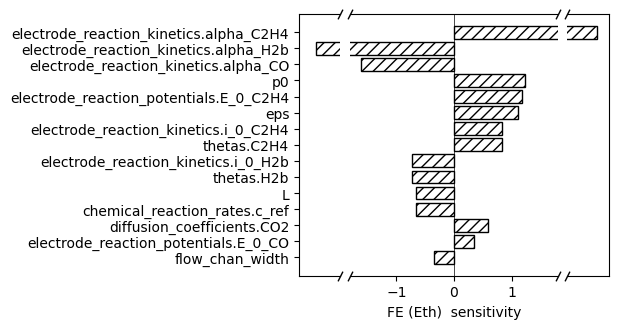

In [7]:
sensitivities = {k: v for k, v in sensitivities.items() if not np.isnan(v)}
# bar chart sorted by sensitivity. bars horizontal
sorted_sensitivities = dict(sorted(sensitivities.items(), key=lambda item: abs(item[1]))[-15:])
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(4,3.4), width_ratios=[0.2,1,0.2])
fig.subplots_adjust(wspace=0.1)
ax[0].barh(list(sorted_sensitivities.keys()), list(sorted_sensitivities.values()), ec='k', fc='none', hatch='///')
ax[1].barh(list(range(15)), list(sorted_sensitivities.values()), ec='k', fc='none', hatch='///')
ax[2].barh(list(range(15)), list(sorted_sensitivities.values()), ec='k', fc='none', hatch='///')
ax[1].axvline(x=0, c='k', ls='-', lw=0.5)
ax[0].set_xlim(-7,-5)
ax[1].set_xlim(-1.8,1.8)
ax[2].set_xlim(8,10)

ax[0].spines.right.set_visible(False)
ax[1].spines.left.set_visible(False)
ax[1].tick_params(labelleft=False)  # don't put tick labels at the top
ax[0].set_xticks([])
ax[2].set_xticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[1].spines.right.set_visible(False)
ax[2].spines.left.set_visible(False)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=7,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([1, 1], [0, 1], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 0], [0, 1], transform=ax[1].transAxes, **kwargs)
ax[1].plot([1, 1], [0, 1], transform=ax[1].transAxes, **kwargs)
ax[2].plot([0,0], [0, 1], transform=ax[2].transAxes, **kwargs)

ax[1].set_xlabel(r'FE (Eth)  sensitivity')
plt.savefig('sensitivities.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

C:\Users\ig348\Documents\CO2-catalysis\analytical_models\gde_multi.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer(k, torch.tensor(v))


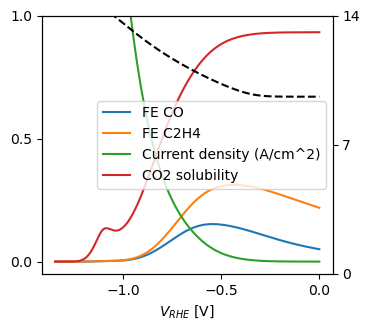

In [8]:
s = System(**init_args)
args = solve_args.copy()
args.pop('i_target')
args['phi_ext'] = torch.linspace(-1,0,500)
results = s.solve(**args)
results['fe_h2'] = 1 - results['fe_c2h4'] - results['fe_co']

fig, ax = plt.subplots(figsize=(3.8,3.4))
plt.plot(results['potential_vs_rhe'], results['fe_co'], label='FE CO')
plt.plot(results['potential_vs_rhe'], results['fe_c2h4'], label='FE C2H4')
plt.plot(results['potential_vs_rhe'], results['current_density']/1000, label='Current density (A/cm^2)')
plt.plot(results['potential_vs_rhe'], results['solubility'], label='CO2 solubility', ls='-')
plt.ylim(-0.05,1)
plt.xticks([-1, -0.5, 0])
plt.yticks([0, 0.5, 1])
plt.xlabel(r'$V_{RHE}$ [V]');
plt.legend()
plt.twinx()
plt.plot(results['potential_vs_rhe'], results['pH'], label='pH', ls='--', c='k')
plt.ylim(0,14)
plt.yticks([0, 7, 14])
fig.tight_layout()
plt.savefig('./example_V.pdf', bbox_inches='tight', pad_inches=0.1)